# Задание 2.2 - Введение в PyTorch

Для этого задания потребуется установить версию PyTorch 1.0

https://pytorch.org/get-started/locally/

В этом задании мы познакомимся с основными компонентами PyTorch и натренируем несколько небольших моделей.<br>
GPU нам пока не понадобится.

Основные ссылки:  
https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html  
https://pytorch.org/docs/stable/nn.html  
https://pytorch.org/docs/stable/torchvision/index.html  

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler, Sampler
from torch.optim.lr_scheduler import MultiStepLR

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

## Как всегда, начинаем с загрузки данных

PyTorch поддерживает загрузку SVHN из коробки.

In [2]:
# First, lets load the dataset
data_train = dset.SVHN('./data/', split='train',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./data/', split='test', 
                      transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

In [3]:
data_train[0]

(tensor([[[-1.5029, -1.8559, -1.8559,  ..., -0.7382, -0.5422, -0.4049],
          [-1.6010, -1.8755, -1.8755,  ..., -1.3657, -0.8363, -0.5225],
          [-1.3657, -1.7971, -1.8363,  ..., -1.6990, -1.4637, -0.7382],
          ...,
          [-0.4637, -0.4441, -0.5422,  ..., -0.1108, -0.1108, -0.1304],
          [-0.5029, -0.4637, -0.5422,  ...,  0.0069, -0.0716, -0.0716],
          [-0.4833, -0.4049, -0.4833,  ...,  0.0265, -0.0127, -0.1304]],
 
         [[-1.6118, -1.7490, -1.8667,  ..., -0.9255, -0.6902, -0.6510],
          [-1.4353, -1.7098, -1.8078,  ..., -1.4353, -1.0627, -0.6706],
          [-1.3961, -1.7882, -1.8667,  ..., -1.6314, -1.3765, -0.8471],
          ...,
          [-0.6118, -0.5922, -0.6510,  ..., -0.1608, -0.1412, -0.1412],
          [-0.5137, -0.6510, -0.7098,  ..., -0.1804, -0.1412, -0.1608],
          [-0.4745, -0.5922, -0.6510,  ..., -0.1608, -0.1412, -0.1216]],
 
         [[-1.6049, -1.9775, -1.9775,  ..., -1.2520, -1.2324, -1.1931],
          [-1.6637, -1.9186,

Теперь мы разделим данные на training и validation с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и validation.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [4]:
data_train

Dataset SVHN
    Number of datapoints: 73257
    Root location: ./data/
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.43, 0.44, 0.47], std=[0.2, 0.2, 0.2])
           )

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

В нашей задаче мы получаем на вход изображения, но работаем с ними как с одномерными массивами. Чтобы превратить многомерный массив в одномерный, мы воспользуемся очень простым вспомогательным модулем `Flattener`.

In [6]:
sample, label = data_train[0]
print("SVHN data sample shape: ", sample.shape)
# As you can see, the data is shaped like an image

# We'll use a special helper module to shape it into a tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)
#x.view(batch_size, -1) - возращает новый тензор с числом строк batch_size и числом колонок сколько получится 

SVHN data sample shape:  torch.Size([3, 32, 32])


In [40]:
batch_size, *_ = sample.shape
print(batch_size, _, sample.shape)
print(sample.shape)
f = Flattener()
print(f.forward(sample).shape)
i = nn.Flatten()
print(i(sample).shape)

3 [32, 32] torch.Size([3, 32, 32])
torch.Size([3, 32, 32])
torch.Size([3, 1024])
torch.Size([3, 1024])


И наконец, мы создаем основные объекты PyTorch:
- `nn_model` - собственно, модель с нейросетью
- `loss` - функцию ошибки, в нашем случае `CrossEntropyLoss`
- `optimizer` - алгоритм оптимизации, в нашем случае просто `SGD`

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
tensor = torch.rand(3,4)
tensor = tensor.to(device)
print(f"Device tensor is stored on: {tensor.device}")

Device tensor is stored on: cuda:0


In [10]:
nn_model = nn.Sequential(
            Flattener(),
            nn.Linear(3*32*32, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10), 
         )
nn_model = nn_model.to(device)
# nn_model.type(torch.FloatTensor)

# We will minimize cross-entropy between the ground truth and
# network predictions using an SGD optimizer
loss = nn.CrossEntropyLoss().type(torch.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)

## Тренируем!

Ниже приведена функция `train_model`, реализующая основной цикл тренировки PyTorch.

Каждую эпоху эта функция вызывает функцию `compute_accuracy`, которая вычисляет точность на validation, эту последнюю функцию предлагается реализовать вам.

In [9]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    val_size = 0
    good_predict = 0
    model.eval() # Evaluation mode
    for i_step, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        good_predict += torch.sum(index == y)
        val_size += X.shape[0]
    
    accuracy =  float(good_predict)/val_size
    
    return accuracy
    
    
    
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    
    raise Exception("Not implemented")
    
    return 0

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 3)

Average loss: 1.796054, Train accuracy: 0.423557, Val accuracy: 0.547062
Average loss: 1.448861, Train accuracy: 0.589786, Val accuracy: 0.602894
Average loss: 1.373197, Train accuracy: 0.624509, Val accuracy: 0.625350


## После основного цикла

Посмотрим на другие возможности и оптимизации, которые предоставляет PyTorch.

Добавьте еще один скрытый слой размера 100 нейронов к модели

In [10]:
# Since it's so easy to add layers, let's add some!

# TODO: Implement a model with 2 hidden layers of the size 100
nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10), 
       )
nn_model = nn_model.to(device)
# nn_model.type(torch.FloatTensor)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-2, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.178212, Train accuracy: 0.192608, Val accuracy: 0.204901
Average loss: 2.010185, Train accuracy: 0.282821, Val accuracy: 0.344072
Average loss: 1.797538, Train accuracy: 0.386735, Val accuracy: 0.404614
Average loss: 1.706839, Train accuracy: 0.420605, Val accuracy: 0.423930
Average loss: 1.683532, Train accuracy: 0.432498, Val accuracy: 0.431575


Добавьте слой с Batch Normalization

In [11]:
# We heard batch normalization is powerful, let's use it!
# TODO: Add batch normalization after each of the hidden layers of the network, before or after non-linearity
# Hint: check out torch.nn.BatchNorm1d

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10), 
         )
nn_model = nn_model.to(device)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=1e-1)
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 2.084321, Train accuracy: 0.300379, Val accuracy: 0.408914
Average loss: 1.785614, Train accuracy: 0.461574, Val accuracy: 0.516484
Average loss: 1.631902, Train accuracy: 0.535884, Val accuracy: 0.562965
Average loss: 1.535539, Train accuracy: 0.579685, Val accuracy: 0.608286
Average loss: 1.470062, Train accuracy: 0.607856, Val accuracy: 0.627193


Добавьте уменьшение скорости обучения по ходу тренировки.

<div class="alert alert-block alert-info">
Посмотри, пожалуйста, я реализовал уменьшение lr. Я использовал MultiStepLR(), а в код модели вставил optimizer.step() в конце цикла по эпохам. 
    
И я же правильно понял, что в аргументе milestones класса MultiStepLR() мы указываем список эпох на которых шаг будет снижатся. 

In [136]:
# This is how to implement the same main train loop in PyTorch. Pretty easy, right?

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
   
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    val_size = 0
    good_predict = 0
    model.eval() # Evaluation mode
    for i_step, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        good_predict += torch.sum(index == y)
        val_size += X.shape[0]
    
    accuracy =  float(good_predict)/val_size
    
    return accuracy
    
    
    
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!



In [13]:
# Learning rate annealing
# Reduce your learning rate 2x every 2 epochs
# Hint: look up learning rate schedulers in PyTorch. You might need to extend train_model function a little bit too!

nn_model = nn.Sequential(
        Flattener(),
        nn.Linear(3*32*32, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.BatchNorm1d(100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10), 
         )
nn_model = nn_model.to(device)

optimizer = optim.SGD(nn_model.parameters(), lr=1e-3, weight_decay=2e-1)
scheduler = MultiStepLR(optimizer, milestones=[ i for i in range(1, 20, 2)],
                        gamma=0.5, verbose=True)

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, 
                                                       loss, optimizer, 20, scheduler)

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-04.
Average loss: 2.069407, Train accuracy: 0.323465, Val accuracy: 0.445840
Adjusting learning rate of group 0 to 5.0000e-04.
Average loss: 1.856269, Train accuracy: 0.460926, Val accuracy: 0.494028
Adjusting learning rate of group 0 to 2.5000e-04.
Average loss: 1.794329, Train accuracy: 0.501109, Val accuracy: 0.523104
Adjusting learning rate of group 0 to 2.5000e-04.
Average loss: 1.759696, Train accuracy: 0.523445, Val accuracy: 0.538598
Adjusting learning rate of group 0 to 1.2500e-04.
Average loss: 1.742375, Train accuracy: 0.534058, Val accuracy: 0.552112
Adjusting learning rate of group 0 to 1.2500e-04.
Average loss: 1.729924, Train accuracy: 0.542999, Val accuracy: 0.552659
Adjusting learning rate of group 0 to 6.2500e-05.
Average loss: 1.723395, Train accuracy: 0.547094, Val accuracy: 0.553955
Adjusting learning rate of group 0 to 6.2500e-05.
Average loss: 1.718628, Train accuracy:

<div class="alert alert-block alert-info">
У нас каждый поинт датасета включает три матрицы на одни лейбел. А почему три? Это как три слоя одного изображения? Просто, по-моему это одно и тоже изображение, которые слегка изменено. 
    

In [14]:
train_loader.dataset[0][0].shape

torch.Size([3, 32, 32])

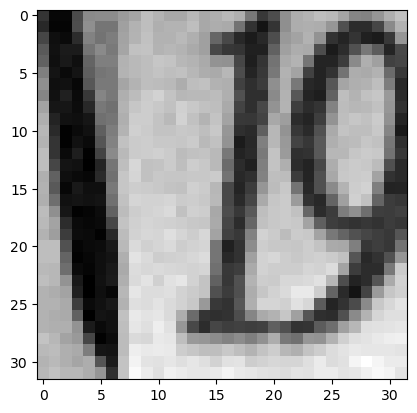

In [15]:
plt.imshow(train_loader.dataset[0][0][0].squeeze(), cmap="gray")

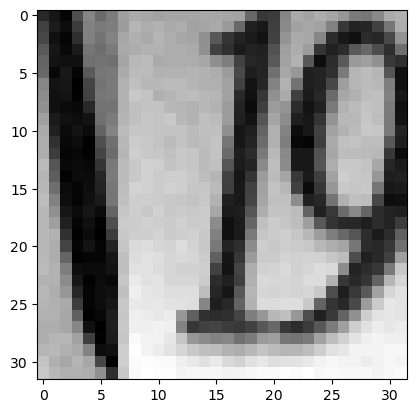

In [16]:
plt.imshow(train_loader.dataset[0][0][1].squeeze(), cmap="gray")

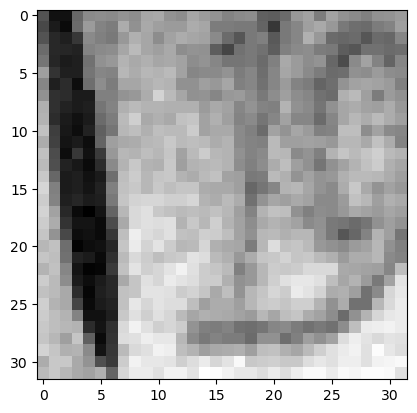

In [17]:
plt.imshow(train_loader.dataset[0][0][2].squeeze(), cmap="gray")

<div class="alert alert-block alert-info">
В 4 лекции (Нейронные сети на практике) говорилось, что применяется техника LR Range test + Cyclical Learning Rate. LR Range test мы перед началом обучения запускам модель чтобы найти лучший максимальный Learning Rate, который мы будем использовать в обучении. Cyclical Learning Rate - мы определяем максимальный и минимальный Learning Rate (например находим максимум при помощи LR Range test , а минимум просто разделив на 10) и в течении эпохи Learning Rate колеблится в этом диапозоне. Идея в том, чтобы выходить из локальных минимумов. 
    
Также там говорилось, что есть Cosine learning rate + Cyclical Learning Rate мы снижаем learning rate по косинусу + делаем это несколько раз. 
    
Что-нибудь из этого актуально и реализовано где-то в pyTorch? 

# Визуализируем ошибки модели

Попробуем посмотреть, на каких изображениях наша модель ошибается.
Для этого мы получим все предсказания модели на validation set и сравним их с истинными метками (ground truth).

Первая часть - реализовать код на PyTorch, который вычисляет все предсказания модели на validation set.  
Чтобы это сделать мы приводим код `SubsetSampler`, который просто проходит по всем заданным индексам последовательно и составляет из них батчи. 

Реализуйте функцию `evaluate_model`, которая прогоняет модель через все сэмплы validation set и запоминает предсказания модели и истинные метки.

In [17]:
nn_model

Sequential(
  (0): Flattener()
  (1): Linear(in_features=3072, out_features=100, bias=True)
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU(inplace=True)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): Linear(in_features=100, out_features=10, bias=True)
)

In [18]:
for num in val_sampler:
    x, y = train_loader.dataset[num]
    print(x.shape)
    print(y)
    break

torch.Size([3, 32, 32])
7


<div class="alert alert-block alert-info">
Дальше я не понял следующее: 
    
- 1. зачем нам класс SubsetSampler(Sampler)? 
    
- 2. Размер передаваемых мной данных torch.Size([3, 32, 32]) (то есть одна картина), но он ругается и, я так понял, требует матрицы другой размерности. Хотя входящий слой модели 3072. Ну то есть размер вектора из матрицы $3*32*32$.

In [82]:
class SubsetSampler(Sampler):
    r"""Samples elements with given indices sequentially

    Arguments:
        indices (ndarray): indices of the samples to take
    """

    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return (self.indices[i] for i in range(len(self.indices)))

    def __len__(self):
        return len(self.indices)
    
    
def evaluate_model(model, dataset, indices):
    """
    Computes predictions and ground truth labels for the indices of the dataset
    
    Returns: 
    predictions: np array of ints - model predictions
    grount_truth: np array of ints - actual labels of the dataset
    """
    model.eval() # Evaluation mode
    predictions = []
    ground_truth = [] 
    for num in indices: 
        X, y = dataset.dataset[num]
        X = X[None, :, :, :]
        X = X.to(device)
        
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        predictions.append(int(index[0]))
        ground_truth.append(y)
    predictions, ground_truth = np.array(predictions), np.array(ground_truth)
    
    
    # TODO: Evaluate model on the list of indices and capture predictions
    # and ground truth labels
    # Hint: SubsetSampler above could be useful!
    return predictions, ground_truth
    raise Exception("Not implemented")
    


# Evaluate model on validation
predictions, gt = evaluate_model(nn_model, train_loader, val_indices)
assert len(predictions) == len(val_indices)
assert len(gt) == len(val_indices)
assert gt[100] == data_train[val_indices[100]][1]
assert np.any(np.not_equal(gt, predictions))

In [122]:
train_loader.dataset[val_indices[2]][0].shape

torch.Size([3, 32, 32])

In [83]:
predictions

array([1, 5, 1, ..., 1, 4, 1])

In [84]:
gt

array([2, 5, 1, ..., 1, 4, 1])

In [26]:
np.unique(gt).shape[0]

10

In [33]:
mat[1, 2] += 1

In [35]:
for pred, real in zip(predictions, gt):
    mat[pred, real] += 1

## Confusion matrix
Первая часть визуализации - вывести confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix ).

Confusion matrix - это матрица, где каждой строке соответствуют классы предсказанный, а столбцу - классы истинных меток (ground truth). Число с координатами `i,j` - это количество сэмплов класса `j`, которые модель считает классом `i`.

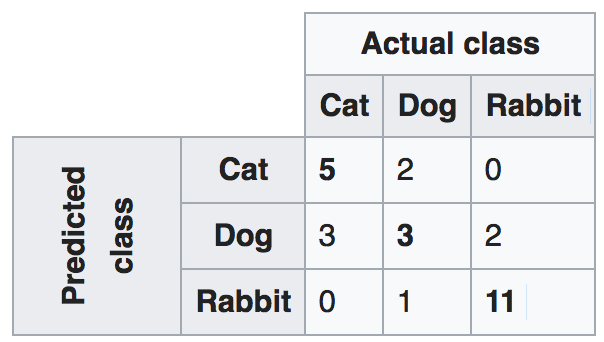

Для того, чтобы облегчить вам задачу, ниже реализована функция `visualize_confusion_matrix` которая визуализирует такую матрицу.  
Вам осталось реализовать функцию `build_confusion_matrix`, которая ее вычислит.

Результатом должна быть матрица 10x10.

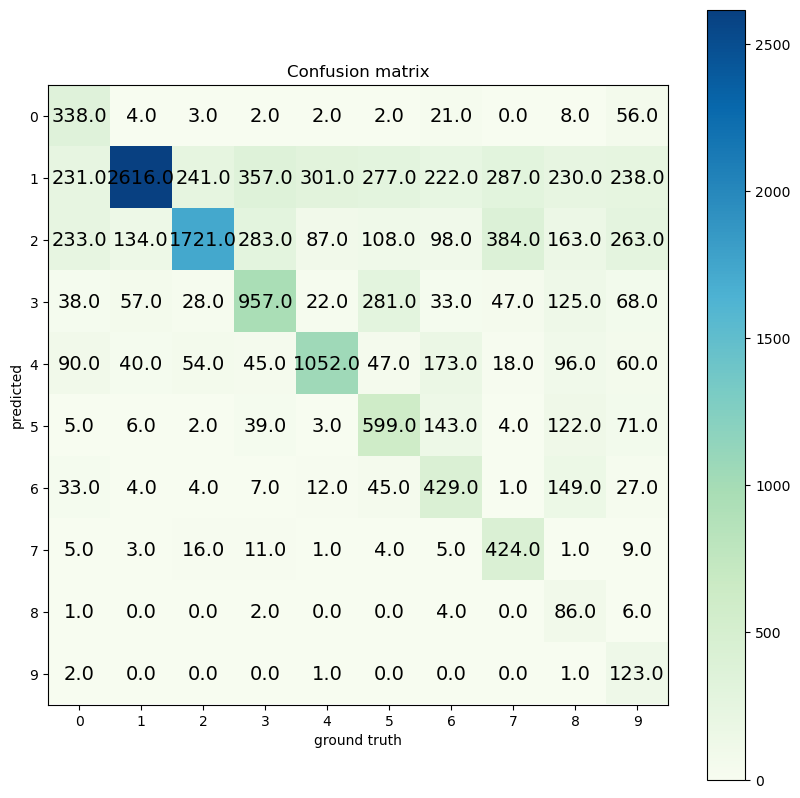

In [37]:
def visualize_confusion_matrix(confusion_matrix):
    """
    Visualizes confusion matrix
    
    confusion_matrix: np array of ints, x axis - predicted class, y axis - actual class
                      [i][j] should have the count of samples that were predicted to be class i,
                      but have j in the ground truth
                     
    """
    # Adapted from 
    # https://stackoverflow.com/questions/2897826/confusion-matrix-with-number-of-classified-misclassified-instances-on-it-python
    assert confusion_matrix.shape[0] == confusion_matrix.shape[1]
    size = confusion_matrix.shape[0]
    fig = plt.figure(figsize=(10,10))
    plt.title("Confusion matrix")
    plt.ylabel("predicted")
    plt.xlabel("ground truth")
    res = plt.imshow(confusion_matrix, cmap='GnBu', interpolation='nearest')
    cb = fig.colorbar(res)
    plt.xticks(np.arange(size))
    plt.yticks(np.arange(size))
    for i, row in enumerate(confusion_matrix):
        for j, count in enumerate(row):
            plt.text(j, i, count, fontsize=14, horizontalalignment='center', verticalalignment='center')
    
def build_confusion_matrix(predictions, ground_truth):
    """
    Builds confusion matrix from predictions and ground truth

    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    
    Returns:
    np array of ints, (10,10), counts of samples for predicted/ground_truth classes
    """
    
    # confusion_matrix = np.zeros((10,10), np.int)
    mat = np.zeros([np.unique(predictions).shape[0], np.unique(gt).shape[0]])
    for pred, real in zip(predictions, gt):
        mat[pred, real] += 1
    
    # TODO: Implement filling the prediction matrix
    # return np.array([[40, 2, 3], [10, 50,0], [0, 2, 80]])
    return mat

confusion_matrix = build_confusion_matrix(predictions, gt)
visualize_confusion_matrix(confusion_matrix)

Наконец, посмотрим на изображения, соответствующие некоторым элементам этой матрицы.

Как и раньше, вам дана функция `visualize_images`, которой нужно воспрользоваться при реализации функции `visualize_predicted_actual`. Эта функция должна вывести несколько примеров, соответствующих заданному элементу матрицы.

Визуализируйте наиболее частые ошибки и попробуйте понять, почему модель их совершает.

In [108]:
train_loader.dataset[1][1]

9

In [94]:
data_train_images.dataset[0][1]

AttributeError: 'SVHN' object has no attribute 'dataset'

In [107]:
data_train_images[1][1]

9

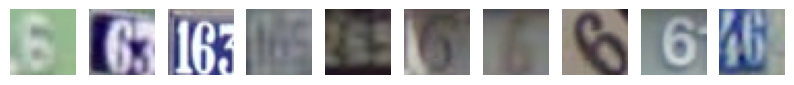

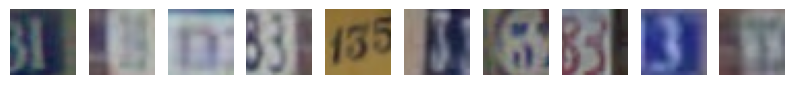

In [119]:
data_train_images = dset.SVHN('./data/', split='train')

def visualize_images(indices, data, title='', max_num=10):
    """
    Visualizes several images from the dataset
 
    indices: array of indices to visualize
    data: torch Dataset with the images
    title: string, title of the plot
    max_num: int, max number of images to display
    """
    to_show = min(len(indices), max_num)
    fig = plt.figure(figsize=(10,1.5))
    fig.suptitle(title)
    for i, index in enumerate(indices[:to_show]):
        plt.subplot(1,to_show, i+1)
        plt.axis('off')
        sample = data[index][0]
        plt.imshow(sample)
        
def visualize_predicted_actual(predicted_class, gt_class, predictions, groud_truth, val_indices, data):
    """
    Visualizes images of a ground truth class which were predicted as the other class 
    
    predicted: int 0-9, index of the predicted class
    gt_class: int 0-9, index of the ground truth class
    predictions: np array of ints, model predictions for all validation samples
    ground_truth: np array of ints, ground truth for all validation samples
    val_indices: np array of ints, indices of validation samples
    """

    # TODO: Implement visualization using visualize_images above
    # predictions and ground_truth are provided for validation set only, defined by val_indices
    # Hint: numpy index arrays might be helpful
    # https://docs.scipy.org/doc/numpy/user/basics.indexing.html#index-arrays
    # Please make the title meaningful!

    index_list = []
    for index, num in enumerate(val_indices): 
        if predictions[index] == predicted_class and groud_truth[index] == gt_class:
            index_list.append(num)
            
    visualize_images(index_list, data)
    #raise Exception("Not implemented")

visualize_predicted_actual(2, 6, predictions, gt, np.array(val_indices), data_train_images)
visualize_predicted_actual(1, 3, predictions, gt, np.array(val_indices), data_train_images)

# Переходим к свободным упражнениям!

Натренируйте модель как можно лучше - экспериментируйте сами!
Что следует обязательно попробовать:
- перебор гиперпараметров с помощью валидационной выборки
- другие оптимизаторы вместо SGD
- изменение количества слоев и их размеров
- наличие Batch Normalization

Но ограничиваться этим не стоит!

Точность на тестовой выборке должна быть доведена до **80%**

In [ ]:
# Experiment here!

In [84]:
# Как всегда, в конце проверяем на test set
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
test_accuracy = compute_accuracy(rn_model, test_loader)
print("Test accuracy: %2.4f" % test_accuracy)

Test accuracy: 0.9064


# Сделаем реккурентную модель 

In [77]:
kernel = 3
rn_model = nn.Sequential(
            #nn.Flatten(),
            nn.Conv2d(3, 64, kernel_size=kernel, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 48, kernel_size=kernel, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(48, 32, kernel_size=kernel, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 24, kernel_size=kernel, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 16, kernel_size=kernel, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16*16*4, 100),
            nn.ReLU(),
            nn.Linear(100, 10), 
         )
rn_model = rn_model.to(device)

In [78]:
rn_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(32, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Conv2d(24, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (14): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): ReLU()
  (16): MaxPool2d(kernel_size=2

In [79]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
            x = x.to(device)
            y = y.to(device)
            prediction = model(x)    
            loss_value = loss(prediction, y)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / (i_step + 1)
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
   
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    val_size = 0
    good_predict = 0
    model.eval() # Evaluation mode
    for i_step, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        prediction = model(X)
        _, index = torch.max(prediction, 1)
        good_predict += torch.sum(index == y)
        val_size += X.shape[0]
    
    accuracy =  float(good_predict)/val_size
    
    return accuracy

In [83]:
#optimizer = optim.SGD(rn_model.parameters(), lr=2e-3, weight_decay=2e-1)
optimizer = optim.Adam(rn_model.parameters(), lr=2e-3)
scheduler = MultiStepLR(optimizer, milestones=[ i for i in range(1, 50, 2)],
                        gamma=0.6, verbose=True)

loss_history, train_history, val_history = train_model(rn_model, train_loader, val_loader, 
                                                       loss, optimizer, 50, scheduler)

Adjusting learning rate of group 0 to 2.0000e-03.
Adjusting learning rate of group 0 to 1.2000e-03.
Average loss: 0.544484, Train accuracy: 0.831058, Val accuracy: 0.889632


KeyboardInterrupt: 